# Optimization Analysis

## Load Data
Go through each record, load in supporting objects, flatten everything into records, and put into a dataframe.

In [1]:
from datetime import datetime
import recirq
import cirq
import numpy as np
import pandas as pd
from recirq.qaoa.experiments.optimization_tasks import (
    DEFAULT_BASE_DIR,
    DEFAULT_PROBLEM_GENERATION_BASE_DIR,
    OptimizationIterationParameters)

records = []
for record in recirq.iterload_records(dataset_id="2020-03-tutorial", base_dir=DEFAULT_BASE_DIR):
    task = record['task']
    if isinstance(task, OptimizationIterationParameters):
        continue
    result = recirq.load(task, DEFAULT_BASE_DIR)
    pgen_task = task.generation_task
    problem = recirq.load(pgen_task, base_dir=DEFAULT_PROBLEM_GENERATION_BASE_DIR)['problem']
    record['problem'] = problem.graph
    record['problem_type'] = problem.__class__.__name__
    recirq.flatten_dataclass_into_record(record, 'task')
    records.append(record)
df = pd.DataFrame(records)    
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,x,fun,nit,nfev,lowest_energy_found,best_bitstring_found,x_iters,func_vals,model_vals,...,optimal_angles_fun,problem,problem_type,dataset_id,generation_task,device_name,p,algorithm,x0,line_placement_strategy
0,2020-05-18 17:41:17.222540,"[0.30985492719939756, -0.3097547892412967]",-0.81472,10,71,-1.0,"[0, 1, 1]","[[0.3, 0.2], [0.18864066297077586, -0.05029067...","[0.89024, -0.16144, -0.70064, -0.76064, -0.809...","[None, -0.2999516266006031, -1.469228016089652...",...,-0.81744,"(0, 1, 2)",SKProblem,2020-03-tutorial,SKProblemGenerationTask(dataset_id='2020-03-tu...,Syc23-simulator,1,"OptimizationAlgorithm(method='MGD', n_shots=25...","[0.3, 0.2]",None
1,2020-05-18 17:40:43.968618,"[0.4665302933996381, -0.39375008394094513]",-1.38040,10,71,-3.0,"[0, 1, 0, 0]","[[0.3, 0.2], [0.23767407235492208, 0.091446382...","[0.87368, 0.36664, -0.14312, -0.5528, -0.97856...","[None, 0.38032697923005904, -0.167043303227276...",...,-1.39244,"(1, 2, 3, 0)",HardwareGridProblem,2020-03-tutorial,HardwareGridProblemGenerationTask(dataset_id='...,Syc23-simulator,1,"OptimizationAlgorithm(method='MGD', n_shots=25...","[0.3, 0.2]",None
2,2020-05-18 17:41:46.192264,"[0.25747101839055747, -0.2907663258984126]",-1.00208,10,71,-2.0,"[1, 0, 0, 1]","[[0.3, 0.2], [0.26925942126134605, 0.063059608...","[1.34936, 0.42248, -0.2564, -0.52304, -0.87784...","[None, 0.40821832097169397, 0.0615626936119336...",...,-1.00248,"(0, 1, 3, 2)",ThreeRegularProblem,2020-03-tutorial,ThreeRegularProblemGenerationTask(dataset_id='...,Syc23-simulator,1,"OptimizationAlgorithm(method='MGD', n_shots=25...","[0.3, 0.2]",None


## Plot

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style('ticks')

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14, title_fontsize=16)

In [3]:
# Load landscape data
from recirq.qaoa.experiments.p1_landscape_tasks import \
    DEFAULT_BASE_DIR, DEFAULT_PROBLEM_GENERATION_BASE_DIR, DEFAULT_PRECOMPUTATION_BASE_DIR, \
    ReadoutCalibrationTask

records = []
ro_records = []
for record in recirq.iterload_records(dataset_id="2020-03-tutorial", base_dir=DEFAULT_BASE_DIR):
    record['timestamp'] = datetime.fromisoformat(record['timestamp'])
    dc_task = record['task']
    
    if isinstance(dc_task, ReadoutCalibrationTask):
        ro_records.append(record)
        continue
    
    pgen_task = dc_task.generation_task    
    problem = recirq.load(pgen_task, base_dir=DEFAULT_PROBLEM_GENERATION_BASE_DIR)['problem']
    record['problem'] = problem.graph
    record['problem_type'] = problem.__class__.__name__
    record['bitstrings'] = record['bitstrings'].bits
    recirq.flatten_dataclass_into_record(record, 'task')
    recirq.flatten_dataclass_into_record(record, 'generation_task')    
    records.append(record)
    
# Associate each data collection task with its nearest readout calibration
for record in sorted(records, key=lambda x: x['timestamp']):
    record['ro'] = min(ro_records, key=lambda x: abs((x['timestamp']-record['timestamp']).total_seconds()))
    
df_raw = pd.DataFrame(records)    
df_raw.head()

from recirq.qaoa.simulation import hamiltonian_objectives

def compute_energies(row):
    permutation = []
    qubit_map = {}
    for i, q in enumerate(row['qubits']):
        fi = row['final_qubits'].index(q)
        permutation.append(fi)
        qubit_map[i] = q
        
    return hamiltonian_objectives(row['bitstrings'], 
                                  row['problem'], 
                                  permutation,
                                  row['ro']['calibration'],
                                  qubit_map)

# Start cleaning up the raw data
landscape_df = df_raw.copy()
landscape_df = landscape_df.drop(['line_placement_strategy', 
              'generation_task.dataset_id', 
              'generation_task.device_name'], axis=1)

# Compute energies
landscape_df['energies'] = landscape_df.apply(compute_energies, axis=1)
landscape_df = landscape_df.drop(['bitstrings', 'problem', 'ro', 'qubits', 'final_qubits'], axis=1)
landscape_df['energy'] = landscape_df.apply(lambda row: np.mean(row['energies']), axis=1)

# We won't do anything with raw energies right now
landscape_df = landscape_df.drop('energies', axis=1)

# Do timing somewhere else
landscape_df = landscape_df.drop([col for col in landscape_df.columns if col.endswith('_time')], axis=1)

In [4]:
import scipy.interpolate
from recirq.qaoa.simulation import lowest_and_highest_energy

def get_problem_graph(problem_type,
                    n=None,
                    instance_i=0):
    if n is None:
        if problem_type == 'HardwareGridProblem':
            n = 4
        elif problem_type == 'SKProblem':
            n = 3
        elif problem_type == 'ThreeRegularProblem':
            n = 4
        else:
            raise ValueError(repr(problem_type))
    
    r = df_raw[
        (df_raw['problem_type']==problem_type)&
        (df_raw['n_qubits']==n)&
        (df_raw['instance_i']==instance_i)
    ]['problem']
    return r.iloc[0]

def plot_optimization_path_in_landscape(problem_type, res=200, method='nearest', cmap='PuOr'):
    optimization_data = df[df['problem_type'] == problem_type]
    landscape_data = landscape_df[landscape_df['problem_type'] == problem_type]
    xx, yy = np.meshgrid(np.linspace(0, np.pi/2, res), np.linspace(-np.pi/4, np.pi/4, res))
    x_iters = optimization_data['x_iters'].values[0]
    
    min_c, max_c = lowest_and_highest_energy(get_problem_graph(problem_type))
    zz = scipy.interpolate.griddata(
        points=landscape_data[['gamma', 'beta']].values,
        values=landscape_data['energy'].values / min_c,
        xi=(xx, yy),
        method=method,
    )

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    norm = plt.Normalize(max_c/min_c, min_c/min_c)
    cmap = 'RdBu'
    extent=(0, 4, -2, 2)
    
    g = ax.imshow(zz, extent=extent, origin='lower', cmap=cmap, norm=norm, interpolation='none')
    xs, ys = zip(*x_iters)
    xs = np.array(xs) / (np.pi / 8)
    ys = np.array(ys) / (np.pi / 8)
    ax.plot(xs, ys, 'r-')
    ax.plot(xs[0], ys[0], 'rs')### Hardware Grid
    ax.plot(xs[1:-1], ys[1:-1], 'r.')
    ax.plot(xs[-1], ys[-1], 'ro')
    x, y = optimization_data['optimal_angles'].values[0]
    x /= (np.pi / 8)
    y /= (np.pi / 8)
    ax.plot(x, y, 'r*')
    
    ax.set_xlabel(r'$\gamma\ /\ (\pi/8)$')
    ax.set_ylabel(r'$\beta\ /\ (\pi/8)$')
    ax.set_title('Optimization path in landscape')

    fig.colorbar(g, ax=ax, shrink=0.8)
    
def plot_function_values(problem_type):
    data = df[df['problem_type'] == problem_type]
    function_values = data['func_vals'].values[0]
    min_c, _ = lowest_and_highest_energy(get_problem_graph(problem_type))
    function_values = np.array(function_values) / min_c
    x = range(len(function_values))
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    ax.plot(x, function_values, 'o--')
    ax.set_xlabel('Optimization iteration')
    ax.set_ylabel(r'$E / E_{min}$')
    ax.set_title('Optimization function values')

### Hardware Grid

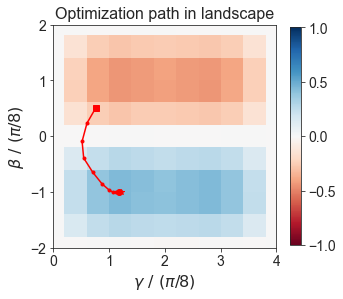

In [5]:
plot_optimization_path_in_landscape('HardwareGridProblem')

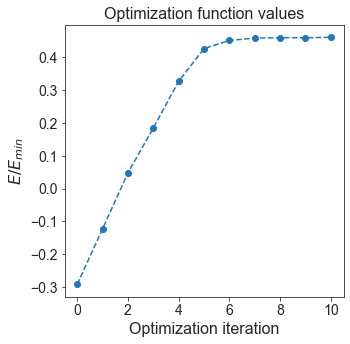

In [6]:
plot_function_values('HardwareGridProblem')

### SK Model

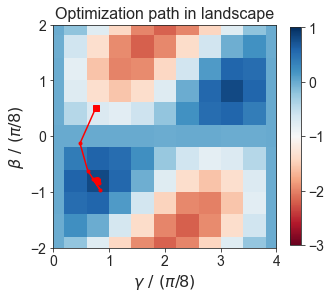

In [7]:
plot_optimization_path_in_landscape('SKProblem')

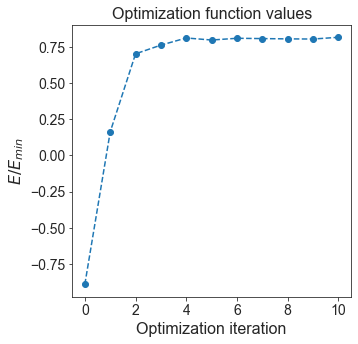

In [8]:
plot_function_values('SKProblem')

### 3 Regular MaxCut

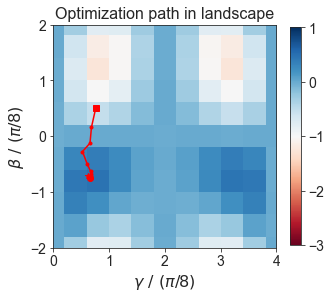

In [9]:
plot_optimization_path_in_landscape('ThreeRegularProblem')

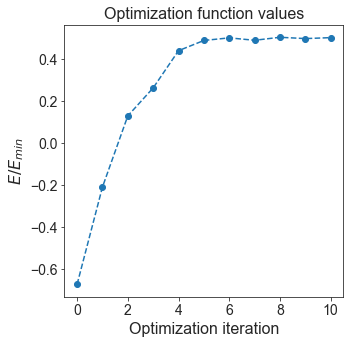

In [10]:
plot_function_values('ThreeRegularProblem')